In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
#### Espa√ßo celular 
##### knowledge susceptible  (S) = 0
##### knowledge contactor    (E) = 1
##### knowledge disseminator (I) = 2
##### knowledge forgetter    (R) = 3
##### knowledge quitter      (Q) = 4

In [81]:
#### DEFINI OS VALORES DAS VARI√ÅVEIS INICIAIS
def set_up_configuration(normalize=(0,1),distribution_type='random'):
    rows, cols = 20, 20
    n_cells = rows * cols  

    # Parametros para fun√ß√£o de mobilidade # Tipo de normaliza√ß√£o padr√£o N(0,1)
    mean = normalize[0]
    stdd = normalize[1] 
    
    # 1. Gerar valores brutos de uma distribui√ß√£o normal N(0,1) -> Padr√£o
    # loc: M√©dia da distribui√ß√£o (centro da curva). 
    # scale: Desvio padr√£o da distribui√ß√£o (espalhamento dos dados).
    raw_r = np.random.normal(loc=mean, scale=stdd, size=n_cells)
    raw_q = np.random.normal(loc=mean, scale=stdd, size=n_cells)

    # 2. Usar o valor absoluto para garantir que sejam n√£o-negativos
    abs_r = np.abs(raw_r)
    abs_q = np.abs(raw_q)
    
    # 3. Calcular a soma total para cada indiv√≠duo
    abs_i = 1 - (abs_r + abs_q)
    total_rates = abs_i + abs_r + abs_q
    
    # Evitar divis√£o por zero 
    total_rates[total_rates == 0] = 1

    # 4. Normalizar as taxas
    forgetting_rate = abs_r / total_rates
    quitting_rate = abs_q / total_rates

    rows_grid, cols_grid = np.mgrid[0:rows, 0:cols]  # Gera um grid
    row_indices = rows_grid.flatten()  # Transforma em array 1D [0, 0, ..., 19, 19]
    col_indices = cols_grid.flatten()  

    pop_status = np.zeros(n_cells, dtype=int)   ## inicia toda a popula√ß√£o com status = 0 (S)
    disseminators = n_cells * 5 // 100  # 95% da populacao √© S e 5% √© I 

    if distribution_type == 'monopolistic':
        center_r, center_c = 17, 10 ##rows // 2, cols // 2
        count = 0
        for r_offset in range(-3, 2):
            for c_offset in range(-3, 2):
                if count < disseminators and -1 < (center_r + r_offset) < rows and -1 < (center_c + c_offset) < cols:
                    idx = (center_r + r_offset) * cols + (center_c + c_offset)
                    pop_status[idx] = 2
                    count += 1
    elif distribution_type == 'small-group':
        coords = [(3, 3), (3, 15), (10, 4), (13, 15), (18,0)]
        count = 0
        for gr, gc in coords:
            for r_offset in range(2):
                for c_offset in range(2):
                     if count < disseminators:
                        idx = (gr + r_offset) * cols + (gc + c_offset)
                        if idx < len(pop_status) and pop_status[idx] == 0:
                            pop_status[idx] = 2
                            count += 1
    else: # 'random'
        pop_status[:disseminators] = 2
        np.random.shuffle(pop_status)

    # Estados poss√≠veis 0=S, 1=E, 2=I, 3=R, 4=Q 
    # Cria o dataframe com a popula√ß√£o e seus Parametros individuais
    data = {
        'row': row_indices,
        'col' : col_indices,
        'status': pop_status,
        'learningCapability': np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_cells)),
        'transferCapability': np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_cells)),
        'forgettingRate': forgetting_rate, 
        'quittingRate': quitting_rate, 
        'timesContactor': np.zeros(n_cells).astype(int)
    }
    name_cols = ['row', 'col','status', 'learningCapability', 'transferCapability','absorptionRate','forgettingRate', 'quittingRate', 'timesContactor']

    # Create DataFrame
    df = pd.DataFrame(data, columns=name_cols)
    return (df)

In [12]:
# Testar 
tipos=['random','monopolistic','small-group']
for i in range(3):
    cellularGrid = set_up_configuration(distribution_type = tipos[i])  
    # Verify the shape and status distribution
    print(f'------------- Tipo: {tipos[i]}')
    print("DataFrame shape:", cellularGrid.shape)
    print("Status distribution:")
    print(cellularGrid['status'].value_counts())

print(cellularGrid.head())

------------- Tipo: random
DataFrame shape: (400, 9)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
------------- Tipo: monopolistic
DataFrame shape: (400, 9)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
------------- Tipo: small-group
DataFrame shape: (400, 9)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
   row  col  status  learningCapability  transferCapability absorptionRate  \
0    0    0       0            0.125296            0.032687            NaN   
1    0    1       0            0.238930            0.038501            NaN   
2    0    2       0            1.782372            0.139916            NaN   
3    0    3       0            0.741600            1.394962            NaN   
4    0    4       0            2.016884            0.347301            NaN   

   forgettingRate  quittingRate  timesContactor  
0        0.084030      0.481229               0  
1        0.646597      0.215727              

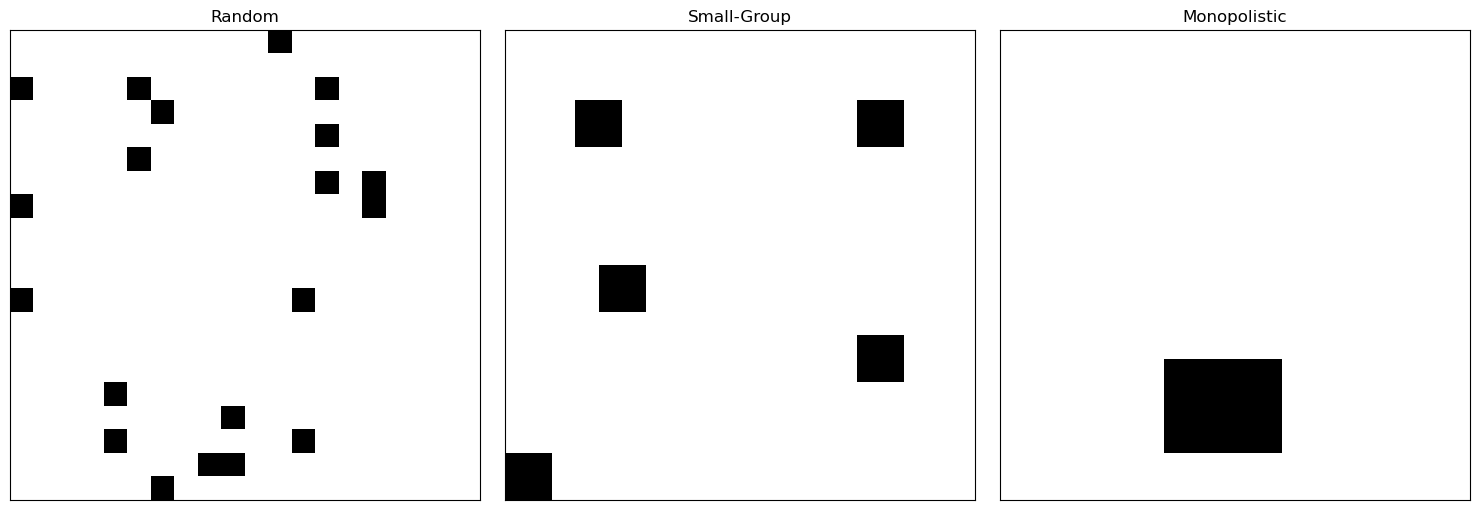

In [70]:
cellularGrid1 = set_up_configuration()   ## padr√£o Random
cellularGrid2 = set_up_configuration(distribution_type = 'small-group')   
cellularGrid3 = set_up_configuration(distribution_type = 'monopolistic')

tipos=['Random','Small-Group','Monopolistic']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
matriz1 = cellularGrid1.pivot(index='row', columns='col', values='status').values
matriz2 = cellularGrid2.pivot(index='row', columns='col', values='status').values
matriz3 = cellularGrid3.pivot(index='row', columns='col', values='status').values

axes[0].imshow(matriz1, cmap='binary')
axes[1].imshow(matriz2, cmap='binary')
axes[2].imshow(matriz3, cmap='binary')

# Configurar cada subplot
i = 0
for ax in axes:
    ax.grid(which='both', color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_title(f"{tipos[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

plt.tight_layout()
plt.show()

In [82]:
def mobility(df, MD=20, IM=20, press=False):
    # Copy DataFrame to avoid modifying the original
    new_df = df.copy()

    max_row = df['row'].max()
    max_col = df['col'].max()
    rows = max_row + 1
    cols = max_col + 1

    if MD > max_row:
        MD = max_row

    columns_to_swap = [col for col in new_df.columns if col not in ['row', 'col']]
       
    # Calculate IMGrid: number of cells to swap = % da popula√ß√£o afetada no movimento
    num_to_move = (len(df) * IM) // 100

    if MD == 0 or num_to_move == 0:
        if press:
            print("Mobilidade n√£o aplic√°vel (MD=0 ou IM=0). Trocas realizadas: 0")
        return new_df
    
    trocas = 0   
    # Perform swaps
    for _ in range(num_to_move):
        # Randomly select first cell (i, j)
        i = np.random.randint(0, max_row)
        j = np.random.randint(0, max_col)
        
        # Randomly select second cell (mdI, mdJ) within MDGrid 
        mdI = np.random.randint(-MD, MD+1)
        mdJ = np.random.randint(-MD, MD+1)
        while mdI == i and mdJ == j:  # Ensure different cells
            mdI = np.random.randint(-MD, MD+1)
            mdJ = np.random.randint(-MD, MD+1)

        mdI = (i + mdI) % rows # Fronteira toroidal
        mdJ = (j + mdJ) % cols # Fronteira toroidal

        # Find indices in DataFrame
        idx1 = new_df[(new_df['row'] == i) & (new_df['col'] == j)].index
        idx2 = new_df[(new_df['row'] == mdI) & (new_df['col'] == mdJ)].index
        
        if idx1.empty or idx2.empty:
            continue  # Skip if indices not found
        if idx1 == idx2:
            continue  # Skip if indices not found
        
        idx1, idx2 = idx1[0], idx2[0]    

        # Swap all attributes except row and col
        temp = new_df.loc[idx1, columns_to_swap].copy()
        new_df.loc[idx1, columns_to_swap] = new_df.loc[idx2, columns_to_swap]
        new_df.loc[idx2, columns_to_swap] = temp
        trocas += 1
    if press:
        print("Trocas realizadas: ",trocas)
        
    return new_df    

In [15]:
teste = 35
print(cellularGrid.iloc[teste])
print("------------------------------------")
df = mobility(cellularGrid,press=True)
print(df.iloc[teste])

row                          1
col                         15
status                       0
learningCapability    0.606944
transferCapability    0.706236
absorptionRate             NaN
forgettingRate        0.438716
quittingRate          0.395985
timesContactor               0
Name: 35, dtype: object
------------------------------------
Trocas realizadas:  80
row                          1
col                         15
status                       0
learningCapability     0.95208
transferCapability    0.219167
absorptionRate             NaN
forgettingRate        0.773011
quittingRate          0.076299
timesContactor               0
Name: 35, dtype: object


In [83]:
def neighborsF(df, point, radius=1, neighbors='Moore'):
    row, col = point
    neighbor_indices =[]
    rows = df['row'].max() + 1
    cols = df['col'].max() + 1   
    
    if neighbors not in ['Moore', 'VonNeumann']:
        raise ValueError("Escolha Moore ou Von Neumann")
    
    for dx in range(- radius, radius + 1):
        for dy in range(- radius, radius + 1):
            if dx == 0 and dy == 0:
                continue  # ignora a pr√≥pria c√©lula

            nx = (row + dx) % rows
            ny = (col + dy) % cols
            
            if neighbors == "VonNeumann":
                dist = abs(dx) + abs(dy)  # dist√¢ncia de Manhattan para validar o vizinho
                if dist <= radius:
                    dist = math.sqrt(dx**2 + dy**2) # dist√¢ncia Euclidiana
                    neighbor_indices.append([df[(df['row'] == nx) & (df['col'] == ny)].index,dist])

            elif neighbors == "Moore":  # Moore inclui todas as c√©lulas no quadrado
                dist = math.sqrt(dx**2 + dy**2)  # dist√¢ncia Euclidiana
                neighbor_indices.append([df[(df['row'] == nx) & (df['col'] == ny)].index,dist])
        
    return neighbor_indices

In [18]:
# Test neighbors function
point = (10, 10)  # Center of the grid
moore_neighbors = neighborsF(cellularGrid, point, radius=1, neighbors='Moore')
von_neumann_neighbors = neighborsF(cellularGrid, point, radius=1, neighbors='VonNeumann')
result1 = [[int(item[0][0]), item[1]] for item in moore_neighbors]
print(result1)
result2 = [[int(item[0][0]), item[1]] for item in von_neumann_neighbors]
print(result2)

[[189, 1.4142135623730951], [190, 1.0], [191, 1.4142135623730951], [209, 1.0], [211, 1.0], [229, 1.4142135623730951], [230, 1.0], [231, 1.4142135623730951]]
[[190, 1.0], [209, 1.0], [211, 1.0], [230, 1.0]]


In [84]:
def acquisition_rate(df, idx_current, radius, neighbors):
    # LearningCapability do ponto atual 
    row = df.loc[idx_current, 'row']
    col = df.loc[idx_current, 'col']
    point = (row,col)
    lc_current = df.loc[idx_current, 'learningCapability']

    # Obter vizinhos com suas dist√¢ncias
    neighbor_data = neighborsF(df, point, radius=radius, neighbors=neighbors)

    max_tax = 0
    for indices, dist in neighbor_data:
        if dist == 0:
            continue
        idx = indices[0]  # √≠ndice do vizinho no DataFrame

        status_vizinho = df.loc[idx, 'status']
        if status_vizinho == 2:  # status = I
            tc_vizinho = df.loc[idx, 'transferCapability']   
            # knowledge acquisition rate
            tax = (1 / dist) * math.sqrt(lc_current * tc_vizinho)

            if tax > max_tax:
                max_tax = tax

    return max_tax

In [20]:
def apply_transition_S_to_E(df):  ## fun√ß√£o para teste
    indx_S = df[df['status'] == 0][['row', 'col']].index
    transicoes = 0

    for i in indx_S:
        taxa = acquisition_rate(df, i, radius=1, neighbors='Moore')
        if taxa > np.random.random() :
            transicoes += 1

    print(f'Total de transi√ß√µes S ‚Üí E realizadas: {transicoes}')

cellularGrid = set_up_configuration()  #padr√£o    nomalize=0.25,distribution_type='random'
apply_transition_S_to_E(cellularGrid)

Total de transi√ß√µes S ‚Üí E realizadas: 77


In [ ]:
###### Depois que o S se tornou um E ele pode se tornar um R (forgetter) ou um Q (quitter) 
###### Em especial, o forgetter(R) continuar√° buscando a troca de conhecimento com o disseminator(I), podendo ent√£o se tornar um contactor (E) novamente com certas probabilidades. 
###### Al√©m disso, como o forgetter(R) j√° entrou em contato com o disseminator (I) anteriormente, ele possui alguma base para o conhecimento espec√≠fico.
###### Portanto, a capacidade de aprendizagem do forgetter(R) deve ser maior do que seu antigo status de susceptible (S)
###### Por outro lado, a capacidade de transfer√™ncia do disseminator(I) aumenta na pr√°tica da troca de conhecimento. 
###### No entanto, o crescimento da capacidade de transfer√™ncia √© sempre muito lento na realidade. 
###### Portanto, supomos que a capacidade de transfer√™ncia do disseminator(I) permanece inalterada durante o processo de difus√£o do conhecimento.        
###### Devido √†s diferentes capacidades de aprendizagem e absor√ß√£o de conhecimento dos indiv√≠duos e aos diferentes valores, complexidades e custos de aprendizagem do conhecimento, o contator(E) se tornar√°, com certas probabilidades, o disseminator(I) o forgether(R) ou o quiter(Q) no momento seguinte. As possibilidades de transi√ß√£o para diferentes n√≠veis de conhecimento s√£o indicadas pela taxa de absor√ß√£o do conhecimento I, taxa de esquecimento R e taxa de desistencia Q que representa I + R + Q = 1
###### Al√©m disso, quando um indiv√≠duo se torna um contactor (E) repetidamente, devido ao efeito de refor√ßo da aprendizagem, supomos que sua taxa de esquecimento (R) e desist√™ncia do conhecimento (Q) diminuir√£o proporcionalmente com o aumento do tempo de transi√ß√£o. 
###### Neste artigo, definimos a taxa de esquecimento(R) como R = R ** D + 1, portanto, a taxa de absor√ß√£o do conhecimento (I) pode ser obtida como I = 1 - R ** D + 1 - Q ** D + 1 > I

###### **** Estados poss√≠veis: 
###### knowledge susceptible  (S) = 0
###### knowledge contactor    (E) = 1
###### knowledge disseminator (I) = 2
###### knowledge forgetter    (R) = 3
###### knowledge quitter      (Q) = 4

In [98]:
def transition_F(df, radius, neighbors):
    new_df = df.copy() # cria uma c√≥pia dos dados para promover as altera√ß√µes no passo seguinte
    indices = df.index

    for idx in indices:
        status, D = df.loc[idx, ['status', 'timesContactor']]
        #if D==0: ### evitar divis√£o por 0
        #    D=1
        
        ## Transi√ß√£o de S para E  
        if status == 0:
            taxa = acquisition_rate(df, idx, radius, neighbors)
            # Se encontrou pelo menos um vizinho com status 2, sortear um numero entre 0 e 1 e se for maior troca
            if taxa > np.random.random():
                new_df.at[idx, 'status'] = 1  # transita de S (0) para E (1)
                new_df.at[idx, 'timesContactor'] += 1

        ## Transi√ß√£o de E para I, R ou Q
        elif status == 1:

            txR_base = df.loc[idx, 'forgettingRate']
            txQ_base = df.loc[idx, 'quittingRate']

            # Ajuste com refor√ßo de aprendizado, conforme o artigo 
            Rl = txR_base ** (D + 1)
            Ql = txQ_base ** (D + 1)
    
            # A taxa de absor√ß√£o (Il) deve aumentar. O artigo define I' = 1 - R' - Q' 
            # Isso significa que o que n√£o √© perdido para R ou Q, se torna I.
            Il = 1 - Rl - Ql

            # Normaliza√ß√£o em caso de erro num√©rico
            if Il < 0:
                Il = 0
                total = Rl + Ql
                Rl /= total
                Ql /= total

            # Sorteio do destino
            r = np.random.rand()
            if r < Ql:
                new_df.at[idx, 'status'] = 4  # Q - Quitter
            elif r < Ql + Rl:
                lc_current = df.loc[idx, 'learningCapability']
                new_df.at[idx, 'status'] = 3  # R - Forgetter
                ## incrementa a capacidade de aprendizado 
                new_df.at[idx, 'learningCapability'] = lc_current ** (1.0 / (D+1.0)) if D >= 0 and lc_current > 0 else lc_current
                ####### OBSERVA√á√ÉO: Deveria alterar a taxa ou manter a base original e incrementar ???
                ####### Ser√° que isso pode impactar acelerando a "reaprendizagem" ???
            else:
                new_df.at[idx, 'status'] = 2  # I - Disseminator
        ## transi√ß√£o de R para E
        elif status == 3:         
            taxa = acquisition_rate(df, idx, radius, neighbors)
            if taxa > np.random.random():
                new_df.at[idx, 'status'] = 1  # E - Contactor
    return new_df

In [97]:
def simular_difusao(df, MD=20, IM=50, radius=1, neighbors='Moore', press=False):
    max_iter = 50
    history_stats = [] # resetar hist√≥rico

    for passo in range(1, max_iter + 1):
        status_antes = df['status'].value_counts().to_dict()

        df = transition_F(df, radius, neighbors)
        df = mobility(df,MD,IM)

        status_depois = df['status'].value_counts().to_dict()

        # Salva os dados para gerar estat√≠sticas
        history_stats.append({
            'ciclo': passo,
            **{f'status_{s}': status_depois.get(s, 0) for s in range(5)}
        })

        if press and (passo % 10 == 0):
            print(f'\nüåÄ Ciclo {passo}')
            print(f'Estat√≠sticas:')
            for s in range(5):
                antes = status_antes.get(s, 0)
                depois = status_depois.get(s, 0)
                print(f'  Estado {s}: {antes} ‚Üí {depois}')

        if status_antes == status_depois and press:
            break
    print(f'‚õîÔ∏è Simula√ß√£o encerrada no passo {passo}.')
    return pd.DataFrame(history_stats)

In [ ]:
MD = 20 # Dist√¢ncia m√°xima do salto - varia√ß√µes 0=nenhuma 5,10 e 20=Todo o grid 
IM = 50 # Propor√ß√£o de individuos m√≥veis - varia√ß√µes: 0,20%,50% e 100% 
cellularGrid = set_up_configuration()  #padr√£o    nomalize=0.25,distribution_type='random'
df = cellularGrid.copy()
history = simular_difusao(df, MD=MD, IM=IM, radius=1, neighbors='Moore', press=True)

In [89]:
def plot_results(results_dict, title_prefix, filename, colors=None, linestyles=None, markers=None, n_cells=400):
    """
    Fun√ß√£o gen√©rica para plotar os resultados de qualquer experimento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for name, df_history in results_dict.items():
        df_history['r_t'] = df_history['status_2'] / n_cells
        df_history['v_t'] = df_history['status_2'].diff().fillna(0)
        ax1.plot(df_history['ciclo'], df_history['r_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name) if linestyles else '-', marker='o', markersize=3)
        ax2.plot(df_history['ciclo'], df_history['v_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name, '--') if linestyles else '--', marker='x', markersize=4)
    ax1.set_title('(a) Propor√ß√£o de Disseminadores vs. Tempo')
    ax1.set_xlabel('Ciclos de Tempo')
    ax1.set_ylabel('Propor√ß√£o de Disseminadores ($r_t$)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.set_ylim(0, 1.05)
    ax1.set_xlim(0, 50)
    ax2.set_title('(b) Velocidade de Difus√£o vs. Tempo')
    ax2.set_xlabel('Ciclos de Tempo')
    ax2.set_ylabel('Novos Disseminadores ($v_t$)')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.set_xlim(0, 50)
    fig.suptitle(title_prefix, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=300)
    print(f"Gr√°ficos salvos com sucesso no arquivo '{filename}'")
    plt.close(fig)

In [100]:
# --- FUN√á√ïES DE EXECU√á√ÉO DOS EXPERIMENTOS ---
def run_experiment_figure_4(MD=20,IM=50,radius=1,neighbors='Moore'):
    """Executa as simula√ß√µes para replicar a Figura 4."""
    print("\n--- Iniciando simula√ß√µes para a Figura 4: Impacto da Distribui√ß√£o Inicial ---")
    NUM_RODADAS = 50
    scenarios = ['random', 'small-group', 'monopolistic']
    results = {}
    for scenario in scenarios:
        print(f"  Executando cen√°rio: {scenario.capitalize()} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_grid = set_up_configuration(distribution_type=scenario)  
            history = simular_difusao(initial_grid, MD=MD, IM=IM, radius=radius
                                     ,neighbors=neighbors, press=False)
            rodadas_history.append(history)            
        # Calcula a m√©dia dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[scenario.capitalize()] = avg_history
    plot_results(results,
                 'Impacto da Distribui√ß√£o Inicial dos Disseminadores',
                 'figura_4_simulacao.png',
                 colors={'Random': 'green', 'Small-group': 'orange', 'Monopolistic': 'blue'},
                 linestyles={'Random': '-', 'Small-group': '--', 'Monopolistic': ':'})

def run_experiment_figure_5(MD=20,IM=50):
    """Executa as simula√ß√µes para replicar a Figura 5."""
    print("\n--- Iniciando simula√ß√µes para a Figura 5: Impacto da Vizinhan√ßa ---")
    NUM_RODADAS = 50
    scenarios = {
        '1x1 Von Neumann': {'radius': 1, 'type': 'VonNeumann'},
        '1x1 Moore':       {'radius': 1, 'type': 'Moore'},
        '2x2 Von Neumann': {'radius': 2, 'type': 'VonNeumann'},
        '2x2 Moore':       {'radius': 2, 'type': 'Moore'}
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cen√°rio: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_grid = set_up_configuration()  
            history = simular_difusao(initial_grid.copy(), MD=MD, IM=IM,
                                      radius=params['radius'], neighbors=params['type'], press=False)
            rodadas_history.append(history)
        # Calcula a m√©dia dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Acessibilidade ao Conhecimento (Vizinhan√ßa)',
                 'figura_5_simulacao.png')

def run_experiment_figure_6(MD=20,radius=1,neighbors='Moore'):
    """Executa as simula√ß√µes para replicar a Figura 6 (Impacto da Propor√ß√£o de Indiv√≠duos M√≥veis)."""
    print("\n--- Iniciando simula√ß√µes para a Figura 6: Impacto da Propor√ß√£o de M√≥veis (IM) ---")
    NUM_RODADAS = 50
    scenarios = [0, 20, 50, 100]
    results = {}

    for im_percent in scenarios:
        name = f'IM = {im_percent}%'
        print(f"  Executando cen√°rio: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_grid = set_up_configuration()  
            history = simular_difusao(initial_grid.copy(), MD=MD, IM=im_percent, radius=radius
                                     ,neighbors=neighbors, press=False)
            rodadas_history.append(history)
        # Calcula a m√©dia dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Propor√ß√£o de Indiv√≠duos M√≥veis (IM)',
                 'figura_6_simulacao.png')

def run_experiment_figure_7(IM=50,radius=1,neighbors='Moore'):
    """Executa as simula√ß√µes para replicar a Figura 7 (Impacto da Dist√¢ncia M√°xima de Movimento)."""
    print("\n--- Iniciando simula√ß√µes para a Figura 7: Impacto da Dist√¢ncia de Movimento (MD) ---")
    NUM_RODADAS = 50
    scenarios = [0, 5, 10, 20]
    results = {}
    for md_dist in scenarios:
        name = f'MD = {md_dist}'
        print(f"  Executando cen√°rio: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_grid = set_up_configuration()  
            history = simular_difusao(initial_grid.copy(), 
                                  MD=md_dist, IM=IM,
                                  radius=radius, neighbors=neighbors, press=False)
            rodadas_history.append(history)
        # Calcula a m√©dia dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Dist√¢ncia M√°xima de Movimento (MD)',
                 'figura_7_simulacao.png')

def run_experiment_figure_8(MD=20,IM=100,radius=1,neighbors='Moore'):
    """Executa as simula√ß√µes para replicar a Figura 8 (Impacto da Taxa de Desist√™ncia)."""
    print("\n--- Iniciando simula√ß√µes para a Figura 8: Impacto da Taxa de Desist√™ncia ---")
    NUM_RODADAS = 50
    # Interpretando a nota√ß√£o N(a,b) do artigo como uma distribui√ß√£o Uniforme(a,b)
    # cen√°rios do artigo se√ß√£o 4.4
    scenarios = {
        'Taxa [0-0.25]':    {'min': 0.0, 'max': 0.25},
        'Taxa [0.25-0.5]':  {'min': 0.25, 'max': 0.50},
        'Taxa [0.5-0.75]':  {'min': 0.50, 'max': 0.75},
        'Taxa [0.75-1.0]':  {'min': 0.75, 'max': 1.0} ## no artigo menciona 0,75 a 0,10 (mas acho que √© 0,75 a 1)
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cen√°rio: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_grid = set_up_configuration(normalize=(params['min'],params['max']))
            history = simular_difusao(initial_grid.copy(), MD=MD, IM=IM,
                                      radius=radius, neighbors=neighbors, press=False)
            rodadas_history.append(history)
        # Calcula a m√©dia dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Taxa de Desist√™ncia do Conhecimento',
                 'figura_8_simulacao.png')

In [ ]:
run_experiment_figure_4()
run_experiment_figure_5()
run_experiment_figure_6()
run_experiment_figure_7()
run_experiment_figure_8()

print("\nTodos os experimentos foram conclu√≠dos com sucesso.")


--- Iniciando simula√ß√µes para a Figura 4: Impacto da Distribui√ß√£o Inicial ---
  Executando cen√°rio: Random - (50 rodadas)...
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada no passo 50.
‚õîÔ∏è Simula√ß√£o encerrada 

Soma 0: 1.0
Total:  1.0
Soma 1: 1.0
Total:  1.0
Soma 2: 1.0
Total:  1.0
Soma 3: 1.0
Total:  1.0
Soma 4: 1.0
Total:  1.0


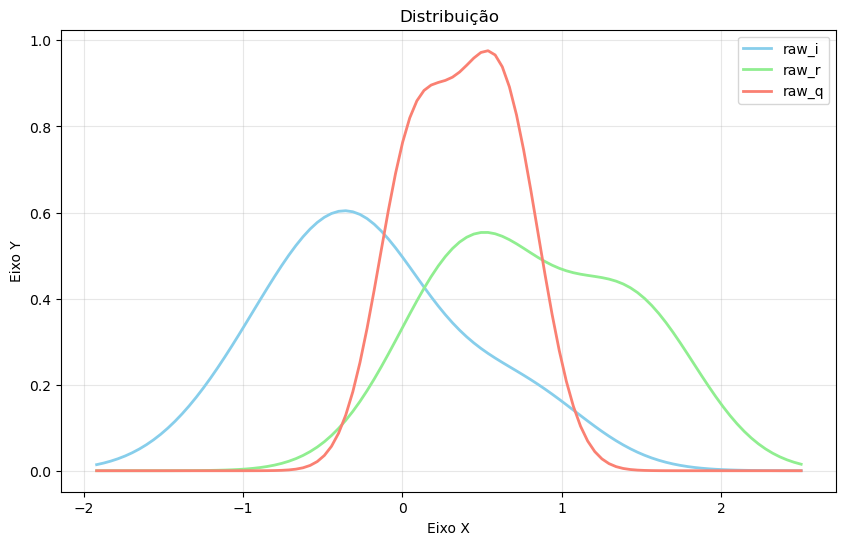

In [59]:
mean = 0
stdd = 0.75
n_cells = 5

# 1. Gerar valores brutos de uma distribui√ß√£o normal N(0,1) -> Padr√£o
#raw_i = np.random.normal(loc=mean, scale=stdd, size=n_cells)
raw_r = np.random.normal(loc=mean, scale=stdd, size=n_cells)
raw_q = np.random.normal(loc=mean, scale=stdd, size=n_cells)

# 2. Usar o valor absoluto para garantir que sejam n√£o-negativos
#abs_i = np.abs(raw_i)
abs_r = np.abs(raw_r)
abs_q = np.abs(raw_q)

# 3. Calcular a soma total para cada indiv√≠duo
abs_i = 1 - (abs_r + abs_q)
total_rates = abs_i + abs_r + abs_q

# Evitar divis√£o por zero 
total_rates[total_rates == 0] = 1

# 4. Normalizar as taxas
apt_rate = abs_i / total_rates
forgetting_rate = abs_r / total_rates
quitting_rate = abs_q / total_rates

for i in range(n_cells):
    print(f'Soma {i}:',apt_rate[i]+forgetting_rate[i]+quitting_rate[i])
    print('Total: ',total_rates[i])

###################### GRAFICOS
raw_i = apt_rate
raw_r = forgetting_rate
raw_q = quitting_rate

from scipy.stats import gaussian_kde
plt.figure(figsize=(10, 6))
x = np.linspace(min(min(raw_i), min(raw_r), min(raw_q))-1, 
               max(max(raw_i), max(raw_r), max(raw_q))+1, 100)

kde_i = gaussian_kde(raw_i)
kde_r = gaussian_kde(raw_r)
kde_q = gaussian_kde(raw_q)

plt.plot(x, kde_i(x), color='skyblue', lw=2, label='raw_i')
plt.plot(x, kde_r(x), color='lightgreen', lw=2, label='raw_r')
plt.plot(x, kde_q(x), color='salmon', lw=2, label='raw_q')

plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title(f'Distribui√ß√£o')
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.show()